In [276]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import numpy as np
from matplotlib.pyplot import figure

In [27]:
cd /content/drive/MyDrive/DeepLearing

/content/drive/MyDrive/DeepLearing


In [28]:
def get_dataset_dataloader(root='datasets/cifar10', split='train', transform=None, batch_size=32, shuffle=True):
    if split == 'train':
        trainset = torchvision.datasets.CIFAR10(root=root, train=True,
                                                download=True, transform=transform)

        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=shuffle, num_workers=2)
        return trainset, trainloader
    
    elif split == 'test':
        
        testset = torchvision.datasets.CIFAR10(root=root, train=False,
                                            download=True, transform=transform)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                shuffle=shuffle, num_workers=2)
        return testset, testloader
    else:
        raise ValueError('Not support split name: {}. Please try train or test.'.format(split))
def get_transform():
    return  torchvision.transforms.Compose(
                [
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # need to change
                ]
            
            )

In [29]:
transform = get_transform()
trainset, trainloader = get_dataset_dataloader(split='train', transform=transform,batch_size=4)
testset, testloader = get_dataset_dataloader(split='test', transform=transform,batch_size=4)

Files already downloaded and verified
Files already downloaded and verified


In [209]:
class iNet(nn.Module):
    def __init__(self):
        super(iNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool1 = nn.MaxPool2d(kernel_size=3,stride=1)

        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.conv3 = nn.Conv2d(32, 64, 5, 1)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 10)
        self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        data_need = []
        x1 = self.conv1(x)
        data_need.append(np.array(x1.cpu()))
        x1 = nn.functional.normalize(x1,dim=3)
        x1 = self.pool1(F.relu(x1))
        data_need.append(np.array(x1.cpu()))
        x1 = self.dropout(x1)

        x2 = self.conv2(x1)
        data_need.append(np.array(x2.cpu()))
        x2 = nn.functional.normalize(x2,dim=3)
        x2 = self.pool2(F.relu(x2))
        data_need.append(np.array(x2.cpu()))
        x2 = self.dropout(x2)


        x3 = self.conv3(x2)
        data_need.append(np.array(x3.cpu()))
        x3 = nn.functional.normalize(x3,dim=3)
        x3 = self.pool3(F.relu(x3))
        data_need.append(np.array(x3.cpu()))
        x3 = self.dropout(x3)

        x4 = torch.flatten(x3, 1)

        z = self.fc1(x4)
        z = F.relu(z)
        z = self.dropout(z)

        output = self.fc2(z)       
        output = self.logSoftmax(output)
        return output,data_need

In [210]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
net = iNet().to(device)
net_optimizer = optim.Adam(lr=0.001,params= net.parameters())

In [211]:
checkpoin = torch.load('weights/model.pth')
net.load_state_dict(checkpoin['model_state_dict'])

<All keys matched successfully>

In [253]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [255]:
def visual(net,index):
    net.eval()
    with torch.no_grad():
        input = trainset[index][0]
        x = input.reshape(1,3,32,32)
        output,data_need = net(x.to(device))
    return input.cpu(),output,data_need

In [290]:
input,output,data_need = visual(net,1)

In [291]:
def normalize(a):
    X = np.zeros_like(a)
    for i in range(X.shape[0]):
        X[i] = (a[i] - np.min(a[i]))/(np.ptp(a[i]) + 1e-9)
    return X

In [292]:
x0 = normalize(data_need[0][0])
x1 = normalize(data_need[1][0])
x2 = normalize(data_need[2][0])
x3 = normalize(data_need[3][0])
x4 = normalize(data_need[4][0])
x5 = normalize(data_need[5][0])

**Original Image**

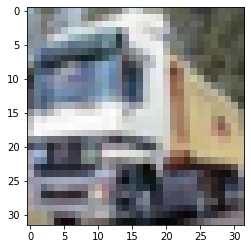

In [293]:
imshow(input)

Layer 1: **16 Conv (5,5)**


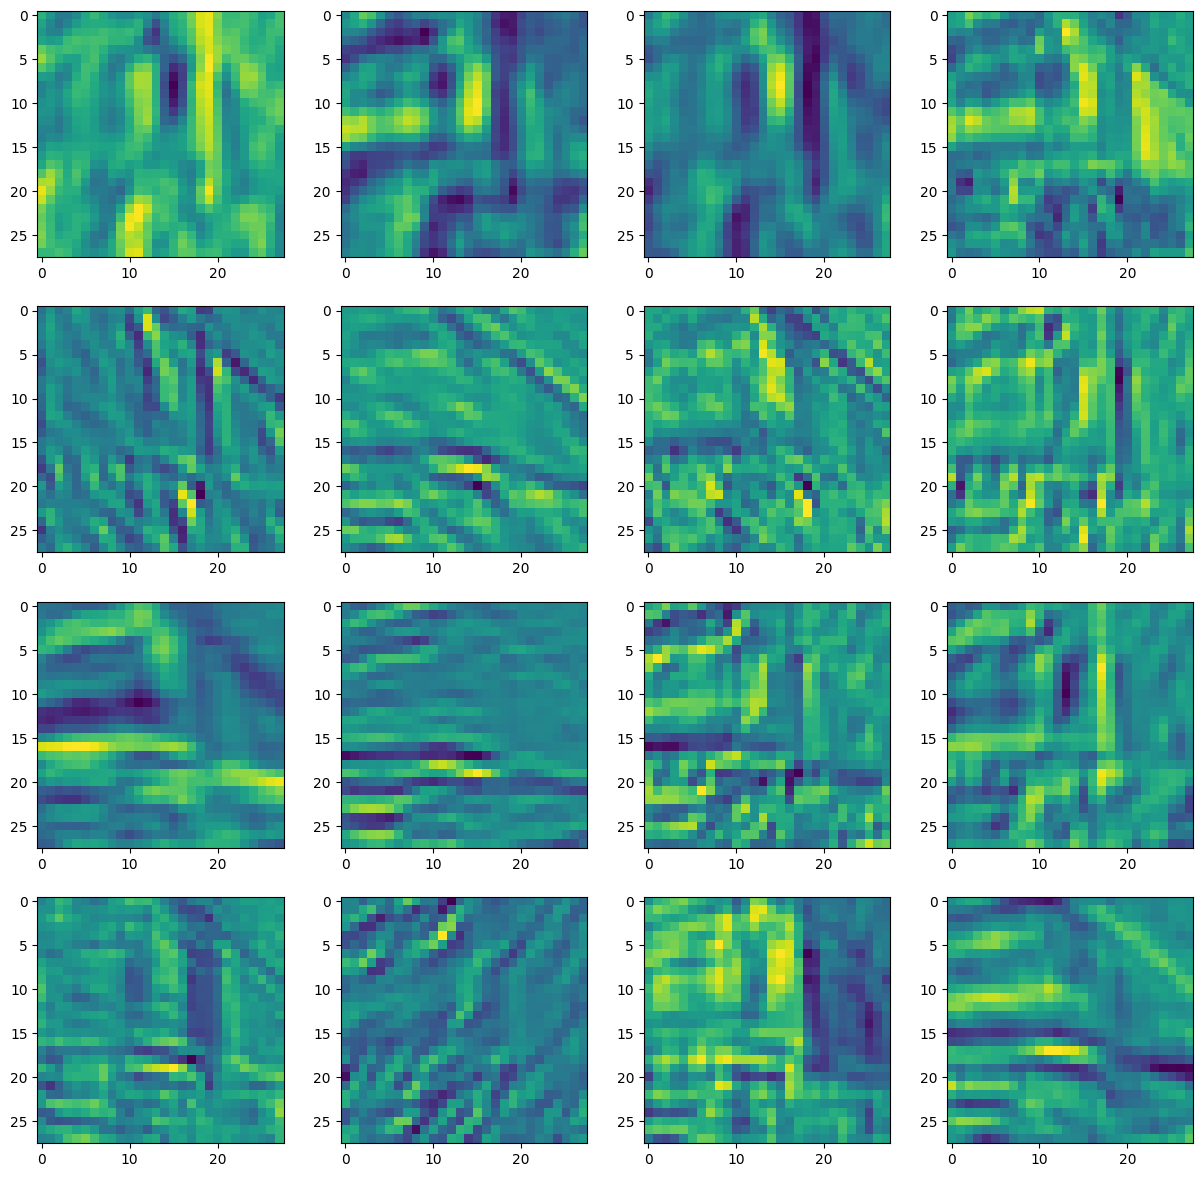

In [294]:

figure(figsize=(15, 15), dpi=100)
for i in range(x0.shape[0]):
    image = x0[i]
    plt.subplot(4,4,i+1)
    plt.imshow(image)
    # plt.savefig('layer01_'+str(i)+'.png')

Layer 1: **MaxPool2d(kernel_size=3,stride=1)**

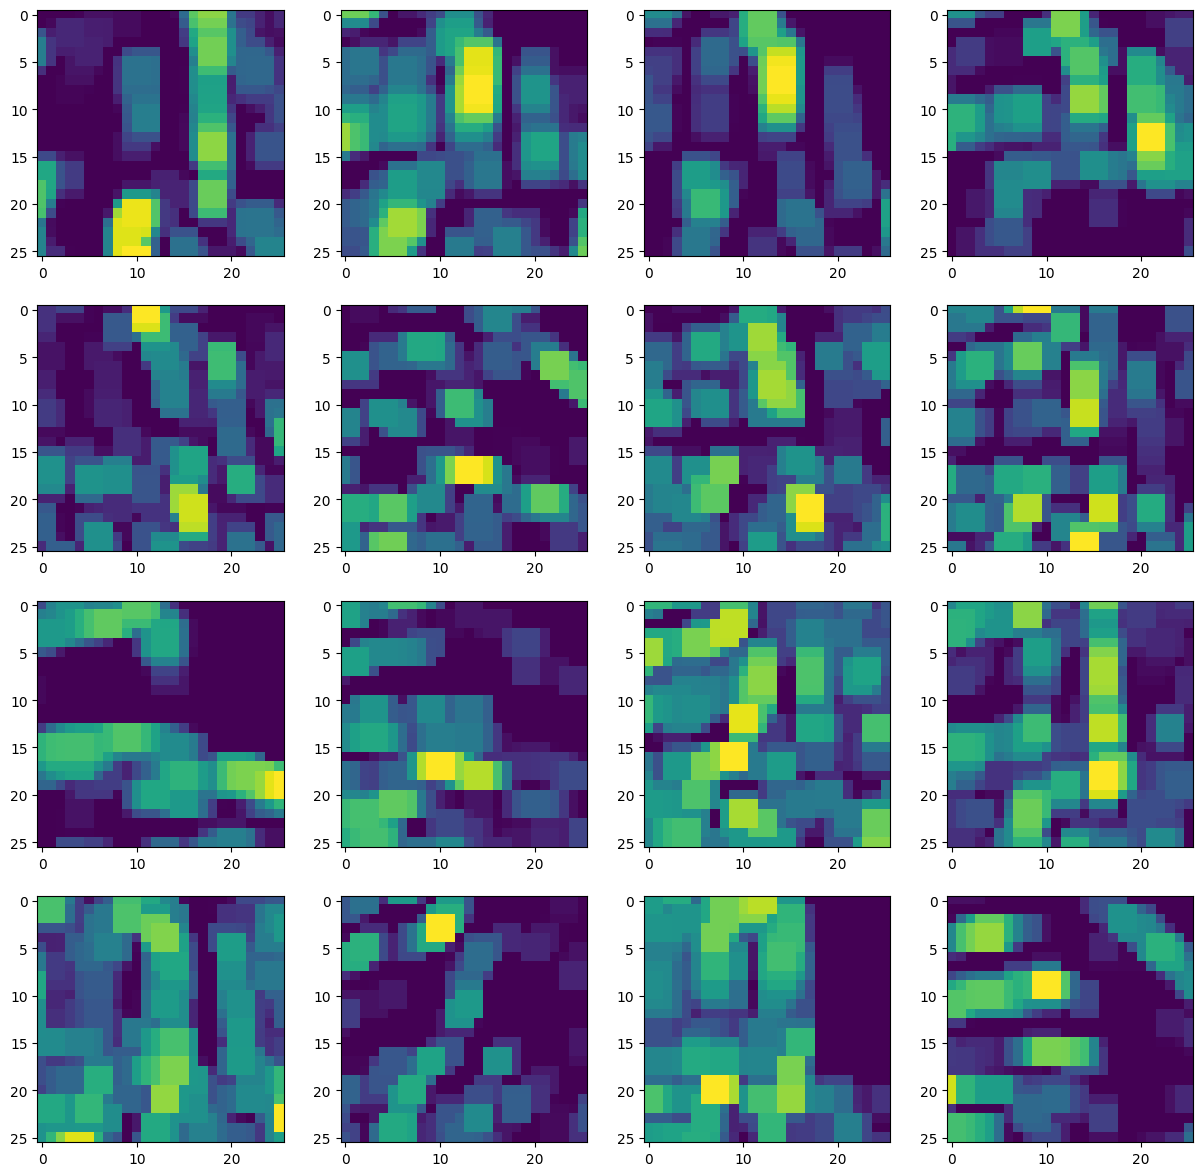

In [295]:
figure(figsize=(15, 15), dpi=100)
for i in range(x1.shape[0]):
    image = x1[i]
    plt.subplot(4,4,i+1)
    plt.imshow(image)

Layer 2: **32 Conv (3,3)**

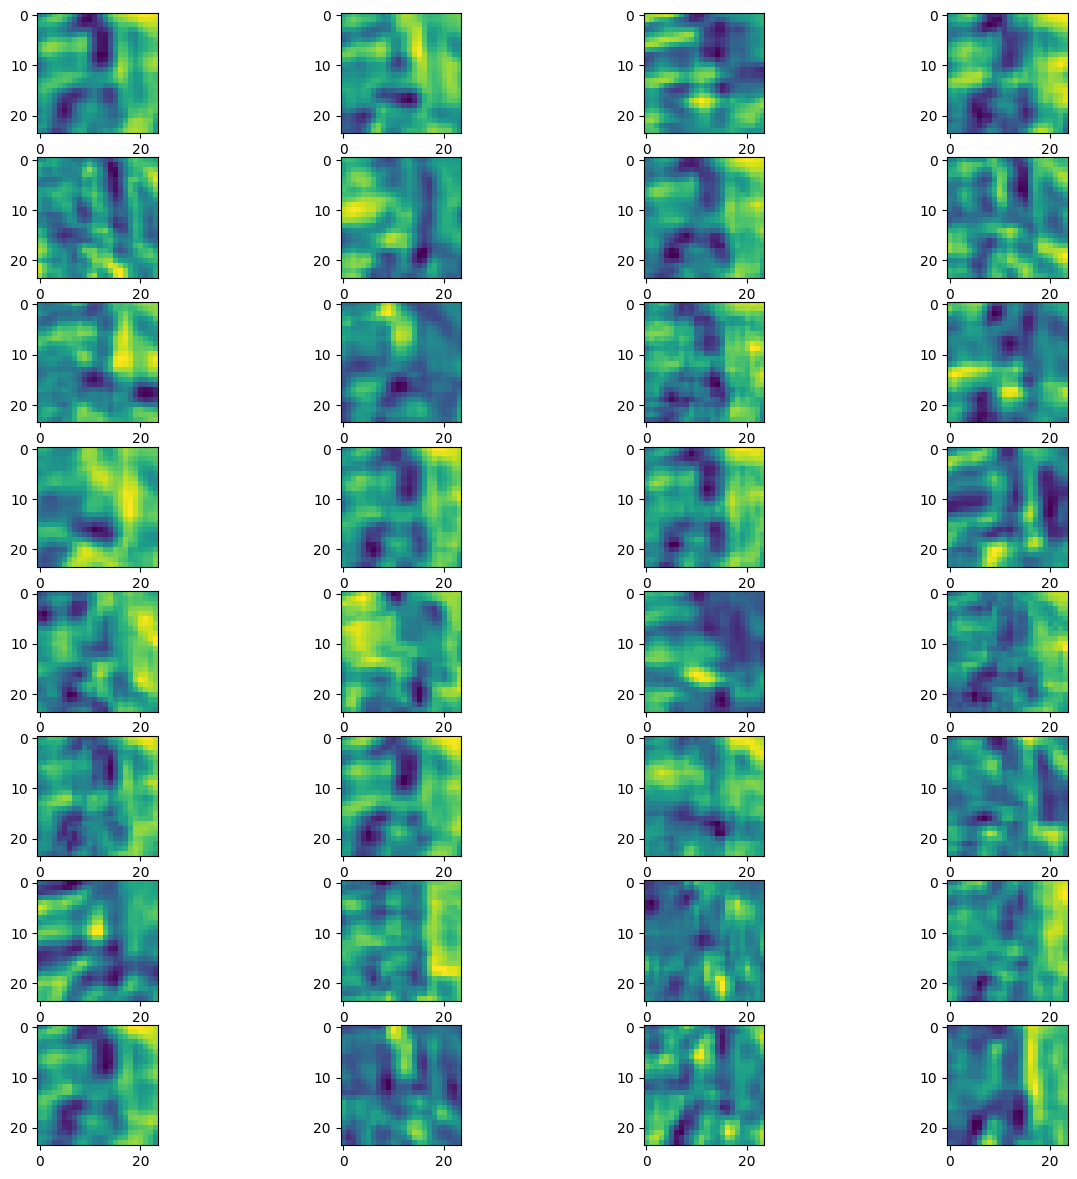

In [296]:
figure(figsize=(15, 15), dpi=100)

for i in range(x2.shape[0]):
    image = x2[i]
    plt.subplot(8,4,i+1)
    plt.imshow(image)

Layer 2: **MaxPool2d(kernel_size=2,stride=2)**

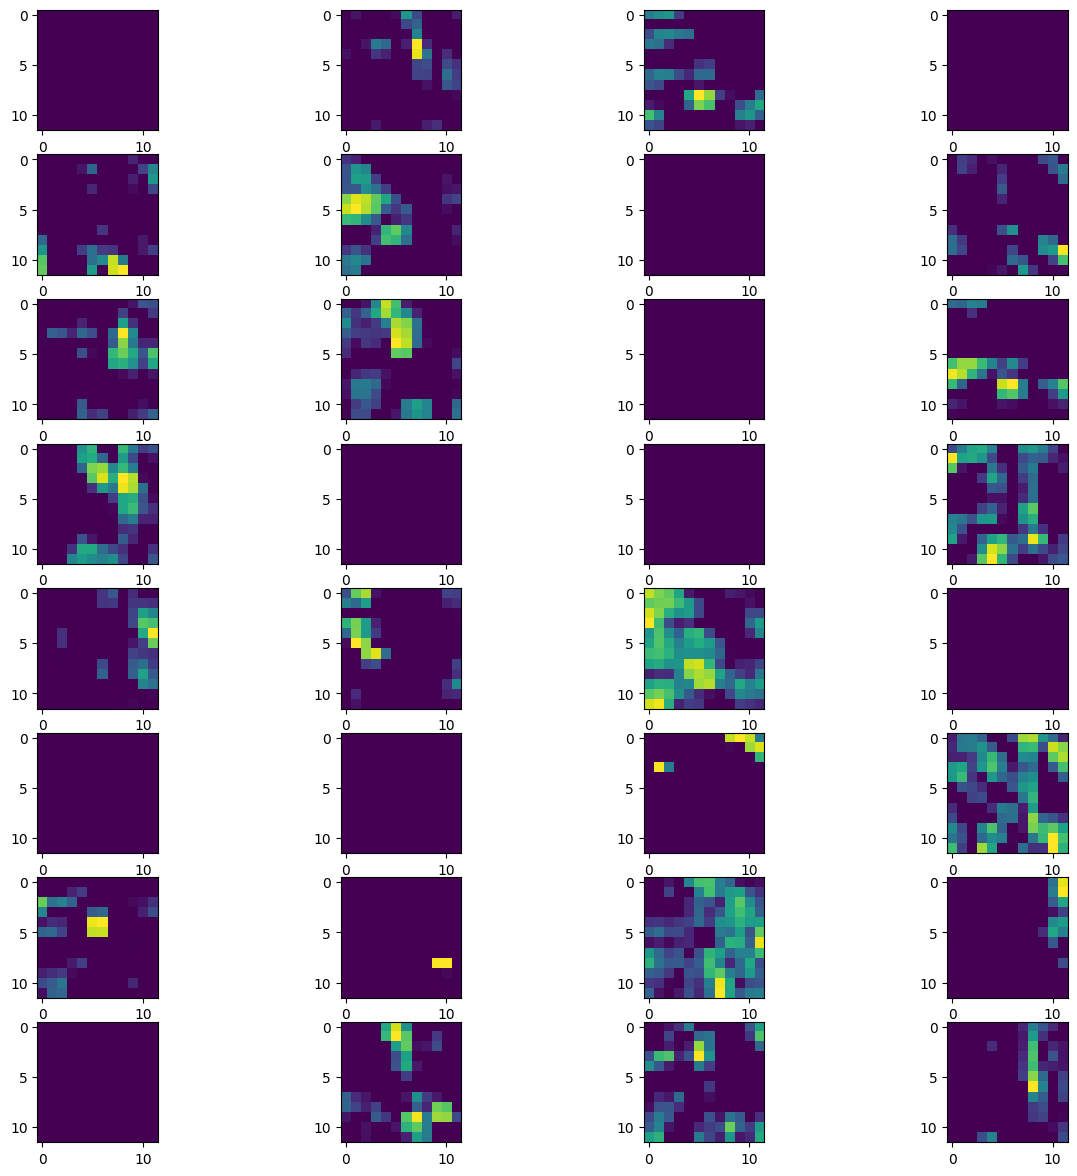

In [297]:
figure(figsize=(15, 15), dpi=100)

for i in range(x3.shape[0]):
    image = x3[i]
    plt.subplot(8,4,i+1)
    plt.imshow(image)

Layer 3: **64 Conv (5,5)**


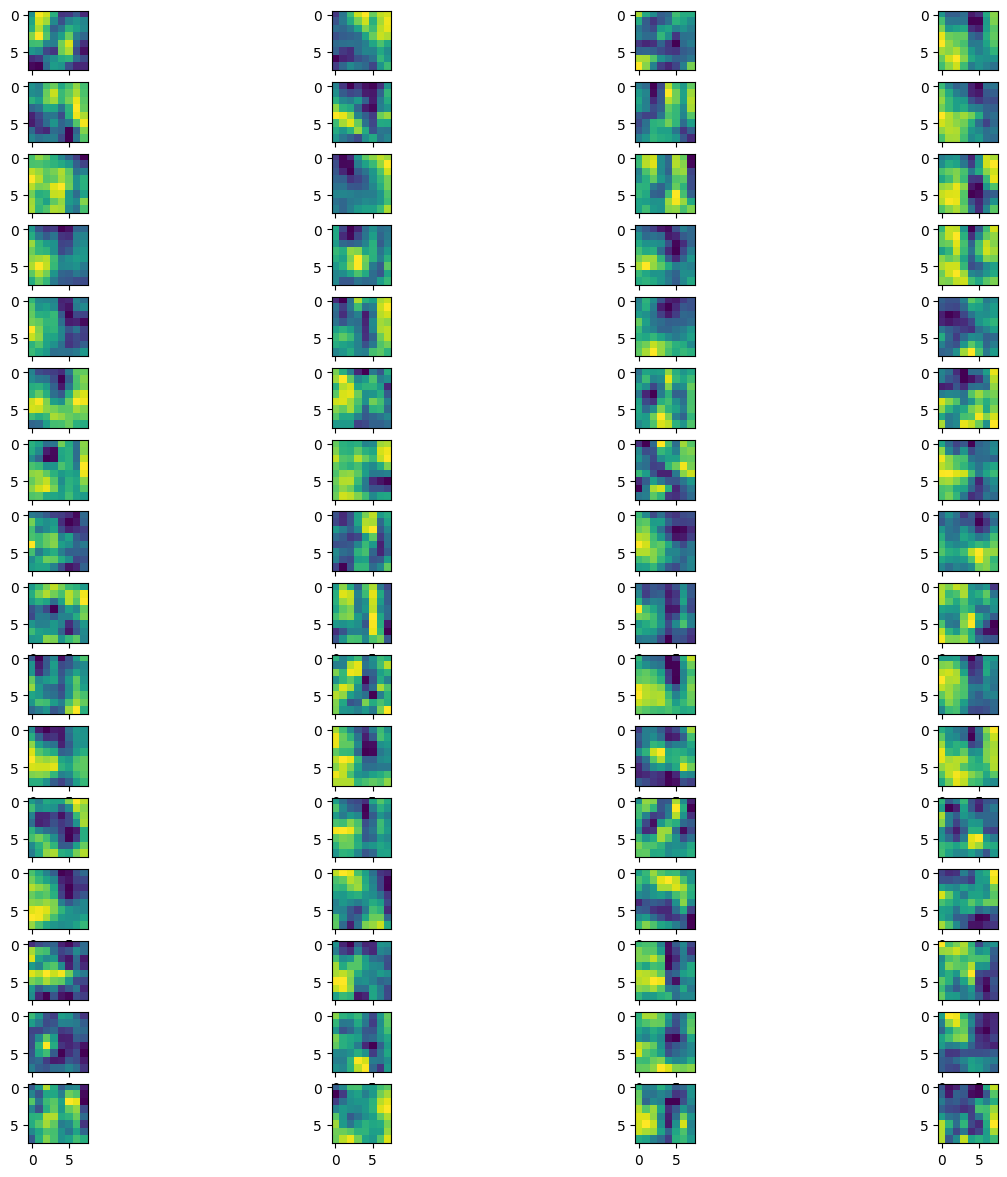

In [298]:
figure(figsize=(15, 15), dpi=100)

for i in range(x4.shape[0]):
    image = x4[i]
    plt.subplot(16,4,i+1)
    plt.imshow(image)

Layer 3: **MaxPool2d(kernel_size=2,stride=2)**

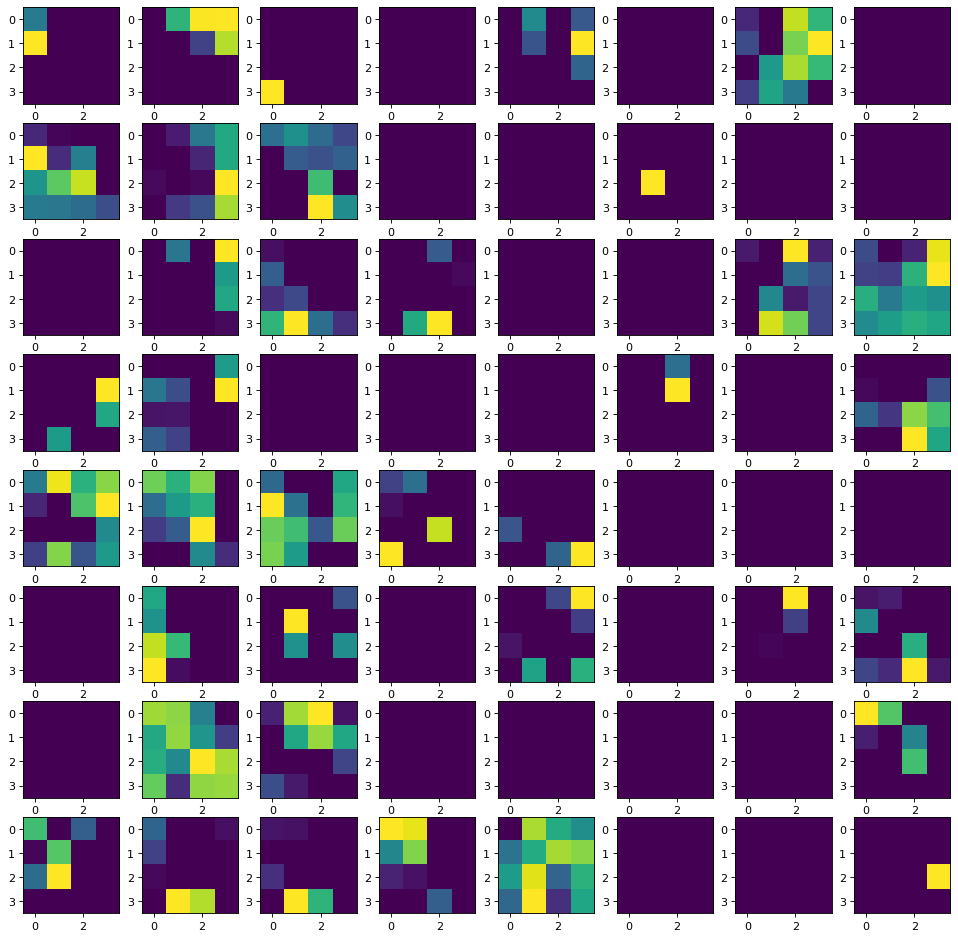

In [299]:
figure(figsize=(15, 15), dpi=80)

for i in range(x5.shape[0]):
    image = x5[i]
    plt.subplot(8,8,i+1)
    plt.imshow(image)